In [177]:
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [178]:
def read_raw_data(dir_path):
    imu = pd.DataFrame()
    imu_time = pd.DataFrame()
    y = pd.DataFrame()
    y_time = pd.DataFrame()
    for f in sorted(os.listdir(dir_path)):
            if f[-7:] == '__x.csv':
                csv_data = pd.read_csv(f'{dir_path}/{f}',
                            header=None,
                            names =['x_accel','y_accel','z_accel','x_gyro','y_gyro','z_gyro'],
                            dtype=np.float64)
                subject = int(f[-13:-10])
                trial = int(f[-9:-7])
                csv_data = csv_data.assign(subject = subject)
                csv_data = csv_data.assign(trial = trial)
                imu = pd.concat([imu, csv_data], axis=0)

            elif f[-12:] == '__x_time.csv':
                csv_data = pd.read_csv(f'{dir_path}/{f}',
                            header=None,
                            names =['x_time'],
                            dtype=np.float64)
                subject = int(f[-18:-15])
                csv_data = csv_data.assign(subject = subject)
                imu_time = pd.concat([imu_time, csv_data], axis=0)

            elif f[-7:] == '__y.csv':
                csv_data = pd.read_csv(f'{dir_path}/{f}',
                            header=None,
                            names =['y'],
                            dtype=np.int8)
                subject = int(f[-13:-10])
                trial = int(f[-9:-7])
                csv_data = csv_data.assign(subject = subject)
                csv_data = csv_data.assign(trial = trial)
                y = pd.concat([y, csv_data], axis=0)

            elif f[-12:] == '__y_time.csv':
                csv_data = pd.read_csv(f'{dir_path}/{f}',
                            header=None,
                            names =['y_time'],
                            dtype=np.float64)
                subject = int(f[-18:-15])
                csv_data = csv_data.assign(subject = subject)
                y_time = pd.concat([y_time, csv_data], axis=0)
                
    imu_data = pd.concat([imu,imu_time['x_time']], axis=1)
    y_data = pd.concat([y,y_time['y_time']],axis = 1)

    return imu_data, y_data

In [179]:
imu_data, y_data = read_raw_data('TrainingData')
df_test, dump = read_raw_data('TestData')
y_data = y_data[['subject','trial','y_time','y']]


In [180]:
# upsamples from 10Hz to 40 Hz
y_10 = y_data['y'].to_numpy(dtype=int)
y_40 = np.empty([4*len(y_10)],dtype=int)

for i in range(0,len(y_10)):
     y_40[4*i] = y_10[i]
     y_40[4*i+1] = y_10[i]
     y_40[4*i+2] = y_10[i]
     y_40[4*i+3] = y_10[i]


In [181]:
# removes a few elements so the sizes match
print('Removing ', len(y_40)-imu_data.shape[0], ' elements from y_40')
y_40 = np.resize(y_40,(imu_data.shape[0],1))
print(imu_data.shape)
print(y_40.shape)
df = imu_data
df['y'] = y_40
#df['y'] = pd.to_numeric(df['y'],errors='coerce')
print(df['y'])
print(df.dtypes)
#print(df['y'].isna())
#df.astype({'y':'int8'})
print(df.dtypes)
df.head()

Removing  6  elements from y_40
(1341646, 9)
(1341646, 1)
0        0
1        0
2        0
3        0
4        0
        ..
48133    0
48134    0
48135    0
48136    0
48137    0
Name: y, Length: 1341646, dtype: int64
x_accel    float64
y_accel    float64
z_accel    float64
x_gyro     float64
y_gyro     float64
z_gyro     float64
subject      int64
trial        int64
x_time     float64
y            int64
dtype: object
x_accel    float64
y_accel    float64
z_accel    float64
x_gyro     float64
y_gyro     float64
z_gyro     float64
subject      int64
trial        int64
x_time     float64
y            int64
dtype: object


,x_accel,y_accel,z_accel,x_gyro,y_gyro,z_gyro,subject,trial,x_time,y
0,4.435275,8.196063,2.974488,0.014215,-0.039157,-0.016744,1,1,0.000,0
1,4.186920,8.344455,2.908057,0.005771,-0.004480,-0.003345,1,1,0.025,0
2,4.544637,8.408659,2.890000,0.007967,0.022412,0.001159,1,1,0.050,0
3,4.849308,8.411614,2.900692,0.027778,-0.010670,-0.014223,1,1,0.075,0
4,4.509190,8.118649,2.847298,0.021577,-0.045498,-0.021111,1,1,0.100,0


In [199]:
class0, class1, class2, class3 = np.bincount(df['y'])
total = class0 + class1 + class2 + class3
print('Examples:\n    Total: {}\n    Class0: {} ({:.2f}% of total)\n Class1: {} ({:.2f}% of total)\n Class2: {} ({:.2f}% of total)\n Class3: {} ({:.2f}% of total)\n'.format(
    total, class0, 100 * class0 / total, class1, 100 * class1 / total, class2, 100 * class2 / total, class3, 100 * class3 / total))

Examples:
    Total: 1341646
    Class0: 1006926 (75.05% of total)
 Class1: 55216 (4.12% of total)
 Class2: 73068 (5.45% of total)
 Class3: 206436 (15.39% of total)



In [182]:
df_test.dropna(axis=0, how='any', inplace=True)
df.dropna(axis=0, how='any', inplace=True)
print(df.head())
print(df.shape)

    x_accel   y_accel   z_accel    x_gyro    y_gyro    z_gyro  subject  trial   
0  4.435275  8.196063  2.974488  0.014215 -0.039157 -0.016744        1      1  \
1  4.186920  8.344455  2.908057  0.005771 -0.004480 -0.003345        1      1   
2  4.544637  8.408659  2.890000  0.007967  0.022412  0.001159        1      1   
3  4.849308  8.411614  2.900692  0.027778 -0.010670 -0.014223        1      1   
4  4.509190  8.118649  2.847298  0.021577 -0.045498 -0.021111        1      1   

   x_time  y  
0   0.000  0  
1   0.025  0  
2   0.050  0  
3   0.075  0  
4   0.100  0  
(1341646, 10)


In [183]:
df_train = df[df['subject'] != 6 ]
df_val = df[df['subject'] == 6 ]
print(df_train.shape)
print(df_val.shape)


(1188830, 10)


In [184]:
# check that upsampling labels is working by making csv files
df_val[['subject','trial','x_time','y']].to_csv('df_val.csv')
y_data[y_data['subject'] == 6].to_csv('y_val_raw.csv')

In [185]:
from sklearn.preprocessing import RobustScaler

scale_columns = ['x_accel', 'y_accel', 'z_accel','x_gyro','y_gyro','z_gyro']

scaler = RobustScaler()

scaler = scaler.fit(df_train[scale_columns])

df_train.loc[:, scale_columns] = scaler.transform(df_train[scale_columns].to_numpy())
df_val.loc[:, scale_columns] = scaler.transform(df_val[scale_columns].to_numpy())
df_test.loc[:, scale_columns] = scaler.transform(df_test[scale_columns].to_numpy())

/Users/javert/.pyenv/versions/3.8.16/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/Users/javert/.pyenv/versions/3.8.16/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/Users/javert/.pyenv/versions/3.8.16/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


In [209]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)
window_in_sec = 2
stride_in_overlap = .5 # percentage of overlap between windows
TIME_STEPS = int(window_in_sec*40)
STEP = int(stride_in_overlap * TIME_STEPS)

X_train, y_train = create_dataset(
    df_train[scale_columns], 
    df_train['y'], 
    TIME_STEPS, 
    STEP
)

X_val, y_val = create_dataset(
    df_val[scale_columns], 
    df_val['y'], 
    TIME_STEPS, 
    STEP
)

X_test, dump = create_dataset(
    df_test[scale_columns], 
    df_test['x_accel'], 
    TIME_STEPS, 
    STEP
)

/var/folders/m_/421bzb5d0h92ss631nbbk9ym0000gn/T/ipykernel_31360/1247866310.py:9: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ys.append(stats.mode(labels)[0][0])
/var/folders/m_/421bzb5d0h92ss631nbbk9ym0000gn/T/ipykernel_31360/1247866310.py:9: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or Fal

In [188]:
print(X_train.shape, y_train.shape)

(19811, 200, 6) (19811, 1)


In [210]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_val = enc.transform(y_val)

/Users/javert/.pyenv/versions/3.8.16/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [190]:
print(X_train.shape, y_train.shape)

(19811, 200, 6) (19811, 4)


In [212]:
batch_size = 1048

# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training_2/cp-best-f1_score.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    monitor = 'val_f1_score',
    mode = 'max',
    save_best_only=True,
 )

In [213]:
import tensorflow_addons as tfa
f1_score = tfa.metrics.F1Score(
    num_classes = 4,
    average = 'macro',
    name = 'f1_score'
)

In [214]:
model = keras.Sequential()
model.add(keras.Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=256, 
          recurrent_dropout = .2
      )
    )
)
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc',f1_score])

model.summary()


Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_21 (Bidirecti  (None, 512)              538624    
 onal)                                                           
                                                                 
 dense_35 (Dense)            (None, 128)               65664     
                                                                 
 dense_36 (Dense)            (None, 4)                 516       
                                                                 
Total params: 604,804
Trainable params: 604,804
Non-trainable params: 0
_________________________________________________________________


In [215]:
# Scaling by total/4 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
'''
weight_for_0 = (1 / class0) * (total / 4.0)
weight_for_1 = (1 / class1) * (total / 4.0)
weight_for_2 = (1 / class2) * (total / 4.0)
weight_for_3 = (1 / class3) * (total / 4.0)
'''
# manuals weights
weight_for_0 = .25
weight_for_1 = 1.2
weight_for_2 = 1.1
weight_for_3 = 2

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))
print('Weight for class 3: {:.2f}'.format(weight_for_3))


Weight for class 0: 0.25
Weight for class 1: 1.20
Weight for class 2: 1.10
Weight for class 3: 2.00


In [216]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=batch_size,
    validation_data = (X_val, y_val),
    shuffle=False,
    callbacks=[cp_callback],
    class_weight=class_weight
)

Epoch 1/20
29/29 [==============================] - ETA: 0s - loss: 0.6111 - acc: 0.4372 - f1_score: 0.3336
Epoch 1: val_f1_score improved from -inf to 0.36667, saving model to training_2/cp-best-f1_score.ckpt
INFO:tensorflow:Assets written to: training_2/cp-best-f1_score.ckpt/assets


INFO:tensorflow:Assets written to: training_2/cp-best-f1_score.ckpt/assets


29/29 [==============================] - 45s 2s/step - loss: 0.6111 - acc: 0.4372 - f1_score: 0.3336 - val_loss: 1.0886 - val_acc: 0.2807 - val_f1_score: 0.3667
Epoch 2/20
29/29 [==============================] - ETA: 0s - loss: 0.4967 - acc: 0.4117 - f1_score: 0.4691
Epoch 2: val_f1_score did not improve from 0.36667
29/29 [==============================] - 62s 2s/step - loss: 0.4967 - acc: 0.4117 - f1_score: 0.4691 - val_loss: 0.9318 - val_acc: 0.3459 - val_f1_score: 0.2942
Epoch 3/20
29/29 [==============================] - ETA: 0s - loss: 0.5083 - acc: 0.3599 - f1_score: 0.4177
Epoch 3: val_f1_score improved from 0.36667 to 0.42367, saving model to training_2/cp-best-f1_score.ckpt
INFO:tensorflow:Assets written to: training_2/cp-best-f1_score.ckpt/assets


INFO:tensorflow:Assets written to: training_2/cp-best-f1_score.ckpt/assets


29/29 [==============================] - 74s 3s/step - loss: 0.5083 - acc: 0.3599 - f1_score: 0.4177 - val_loss: 1.0032 - val_acc: 0.3380 - val_f1_score: 0.4237
Epoch 4/20
29/29 [==============================] - ETA: 0s - loss: 0.4345 - acc: 0.4952 - f1_score: 0.5407
Epoch 4: val_f1_score did not improve from 0.42367
29/29 [==============================] - 65s 2s/step - loss: 0.4345 - acc: 0.4952 - f1_score: 0.5407 - val_loss: 0.9455 - val_acc: 0.3216 - val_f1_score: 0.4235
Epoch 5/20
29/29 [==============================] - ETA: 0s - loss: 0.4198 - acc: 0.4404 - f1_score: 0.5398
Epoch 5: val_f1_score improved from 0.42367 to 0.72657, saving model to training_2/cp-best-f1_score.ckpt
INFO:tensorflow:Assets written to: training_2/cp-best-f1_score.ckpt/assets


INFO:tensorflow:Assets written to: training_2/cp-best-f1_score.ckpt/assets


29/29 [==============================] - 72s 2s/step - loss: 0.4198 - acc: 0.4404 - f1_score: 0.5398 - val_loss: 0.6090 - val_acc: 0.7615 - val_f1_score: 0.7266
Epoch 6/20
29/29 [==============================] - ETA: 0s - loss: 0.4097 - acc: 0.5445 - f1_score: 0.6165
Epoch 6: val_f1_score did not improve from 0.72657
29/29 [==============================] - 63s 2s/step - loss: 0.4097 - acc: 0.5445 - f1_score: 0.6165 - val_loss: 0.6762 - val_acc: 0.6991 - val_f1_score: 0.7046
Epoch 7/20
29/29 [==============================] - ETA: 0s - loss: 0.3627 - acc: 0.5847 - f1_score: 0.6576
Epoch 7: val_f1_score improved from 0.72657 to 0.74120, saving model to training_2/cp-best-f1_score.ckpt
INFO:tensorflow:Assets written to: training_2/cp-best-f1_score.ckpt/assets


INFO:tensorflow:Assets written to: training_2/cp-best-f1_score.ckpt/assets


29/29 [==============================] - 66s 2s/step - loss: 0.3627 - acc: 0.5847 - f1_score: 0.6576 - val_loss: 0.5257 - val_acc: 0.7887 - val_f1_score: 0.7412
Epoch 8/20
29/29 [==============================] - ETA: 0s - loss: 0.3463 - acc: 0.5827 - f1_score: 0.6670
Epoch 8: val_f1_score improved from 0.74120 to 0.78056, saving model to training_2/cp-best-f1_score.ckpt
INFO:tensorflow:Assets written to: training_2/cp-best-f1_score.ckpt/assets


INFO:tensorflow:Assets written to: training_2/cp-best-f1_score.ckpt/assets


29/29 [==============================] - 73s 3s/step - loss: 0.3463 - acc: 0.5827 - f1_score: 0.6670 - val_loss: 0.4364 - val_acc: 0.8675 - val_f1_score: 0.7806
Epoch 9/20
29/29 [==============================] - ETA: 0s - loss: 0.3356 - acc: 0.6364 - f1_score: 0.6892
Epoch 9: val_f1_score did not improve from 0.78056
29/29 [==============================] - 62s 2s/step - loss: 0.3356 - acc: 0.6364 - f1_score: 0.6892 - val_loss: 0.5875 - val_acc: 0.7827 - val_f1_score: 0.7537
Epoch 10/20
29/29 [==============================] - ETA: 0s - loss: 0.3147 - acc: 0.6529 - f1_score: 0.7055
Epoch 10: val_f1_score improved from 0.78056 to 0.80224, saving model to training_2/cp-best-f1_score.ckpt
INFO:tensorflow:Assets written to: training_2/cp-best-f1_score.ckpt/assets


INFO:tensorflow:Assets written to: training_2/cp-best-f1_score.ckpt/assets


29/29 [==============================] - 73s 3s/step - loss: 0.3147 - acc: 0.6529 - f1_score: 0.7055 - val_loss: 0.4137 - val_acc: 0.8788 - val_f1_score: 0.8022
Epoch 11/20
29/29 [==============================] - ETA: 0s - loss: 0.3305 - acc: 0.6245 - f1_score: 0.6986
Epoch 11: val_f1_score did not improve from 0.80224
29/29 [==============================] - 65s 2s/step - loss: 0.3305 - acc: 0.6245 - f1_score: 0.6986 - val_loss: 0.5134 - val_acc: 0.8421 - val_f1_score: 0.7854
Epoch 12/20
29/29 [==============================] - ETA: 0s - loss: 0.3023 - acc: 0.6852 - f1_score: 0.7301
Epoch 12: val_f1_score improved from 0.80224 to 0.80733, saving model to training_2/cp-best-f1_score.ckpt
INFO:tensorflow:Assets written to: training_2/cp-best-f1_score.ckpt/assets


INFO:tensorflow:Assets written to: training_2/cp-best-f1_score.ckpt/assets


29/29 [==============================] - 71s 2s/step - loss: 0.3023 - acc: 0.6852 - f1_score: 0.7301 - val_loss: 0.4930 - val_acc: 0.8560 - val_f1_score: 0.8073
Epoch 13/20
29/29 [==============================] - ETA: 0s - loss: 0.2808 - acc: 0.7035 - f1_score: 0.7420
Epoch 13: val_f1_score improved from 0.80733 to 0.83139, saving model to training_2/cp-best-f1_score.ckpt
INFO:tensorflow:Assets written to: training_2/cp-best-f1_score.ckpt/assets


INFO:tensorflow:Assets written to: training_2/cp-best-f1_score.ckpt/assets


29/29 [==============================] - 70s 2s/step - loss: 0.2808 - acc: 0.7035 - f1_score: 0.7420 - val_loss: 0.3916 - val_acc: 0.8940 - val_f1_score: 0.8314
Epoch 14/20
29/29 [==============================] - ETA: 0s - loss: 0.2636 - acc: 0.7385 - f1_score: 0.7610
Epoch 14: val_f1_score did not improve from 0.83139
29/29 [==============================] - 69s 2s/step - loss: 0.2636 - acc: 0.7385 - f1_score: 0.7610 - val_loss: 0.3614 - val_acc: 0.8932 - val_f1_score: 0.8082
Epoch 15/20
29/29 [==============================] - ETA: 0s - loss: 0.3286 - acc: 0.6639 - f1_score: 0.7229
Epoch 15: val_f1_score did not improve from 0.83139
29/29 [==============================] - 68s 2s/step - loss: 0.3286 - acc: 0.6639 - f1_score: 0.7229 - val_loss: 0.7114 - val_acc: 0.5698 - val_f1_score: 0.6670
Epoch 16/20
29/29 [==============================] - ETA: 0s - loss: 0.3092 - acc: 0.6313 - f1_score: 0.7031
Epoch 16: val_f1_score did not improve from 0.83139
29/29 [===========================

INFO:tensorflow:Assets written to: training_2/cp-best-f1_score.ckpt/assets


29/29 [==============================] - 71s 2s/step - loss: 0.2775 - acc: 0.7101 - f1_score: 0.7462 - val_loss: 0.4111 - val_acc: 0.9026 - val_f1_score: 0.8492
Epoch 18/20
29/29 [==============================] - ETA: 0s - loss: 0.2571 - acc: 0.7733 - f1_score: 0.7820
Epoch 18: val_f1_score did not improve from 0.84915
29/29 [==============================] - 65s 2s/step - loss: 0.2571 - acc: 0.7733 - f1_score: 0.7820 - val_loss: 0.3056 - val_acc: 0.9034 - val_f1_score: 0.8296
Epoch 19/20
29/29 [==============================] - ETA: 0s - loss: 0.2614 - acc: 0.7560 - f1_score: 0.7716
Epoch 19: val_f1_score did not improve from 0.84915
29/29 [==============================] - 72s 2s/step - loss: 0.2614 - acc: 0.7560 - f1_score: 0.7716 - val_loss: 0.4090 - val_acc: 0.8641 - val_f1_score: 0.7461
Epoch 20/20
29/29 [==============================] - ETA: 0s - loss: 0.2714 - acc: 0.7063 - f1_score: 0.7423
Epoch 20: val_f1_score did not improve from 0.84915
29/29 [===========================

In [217]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


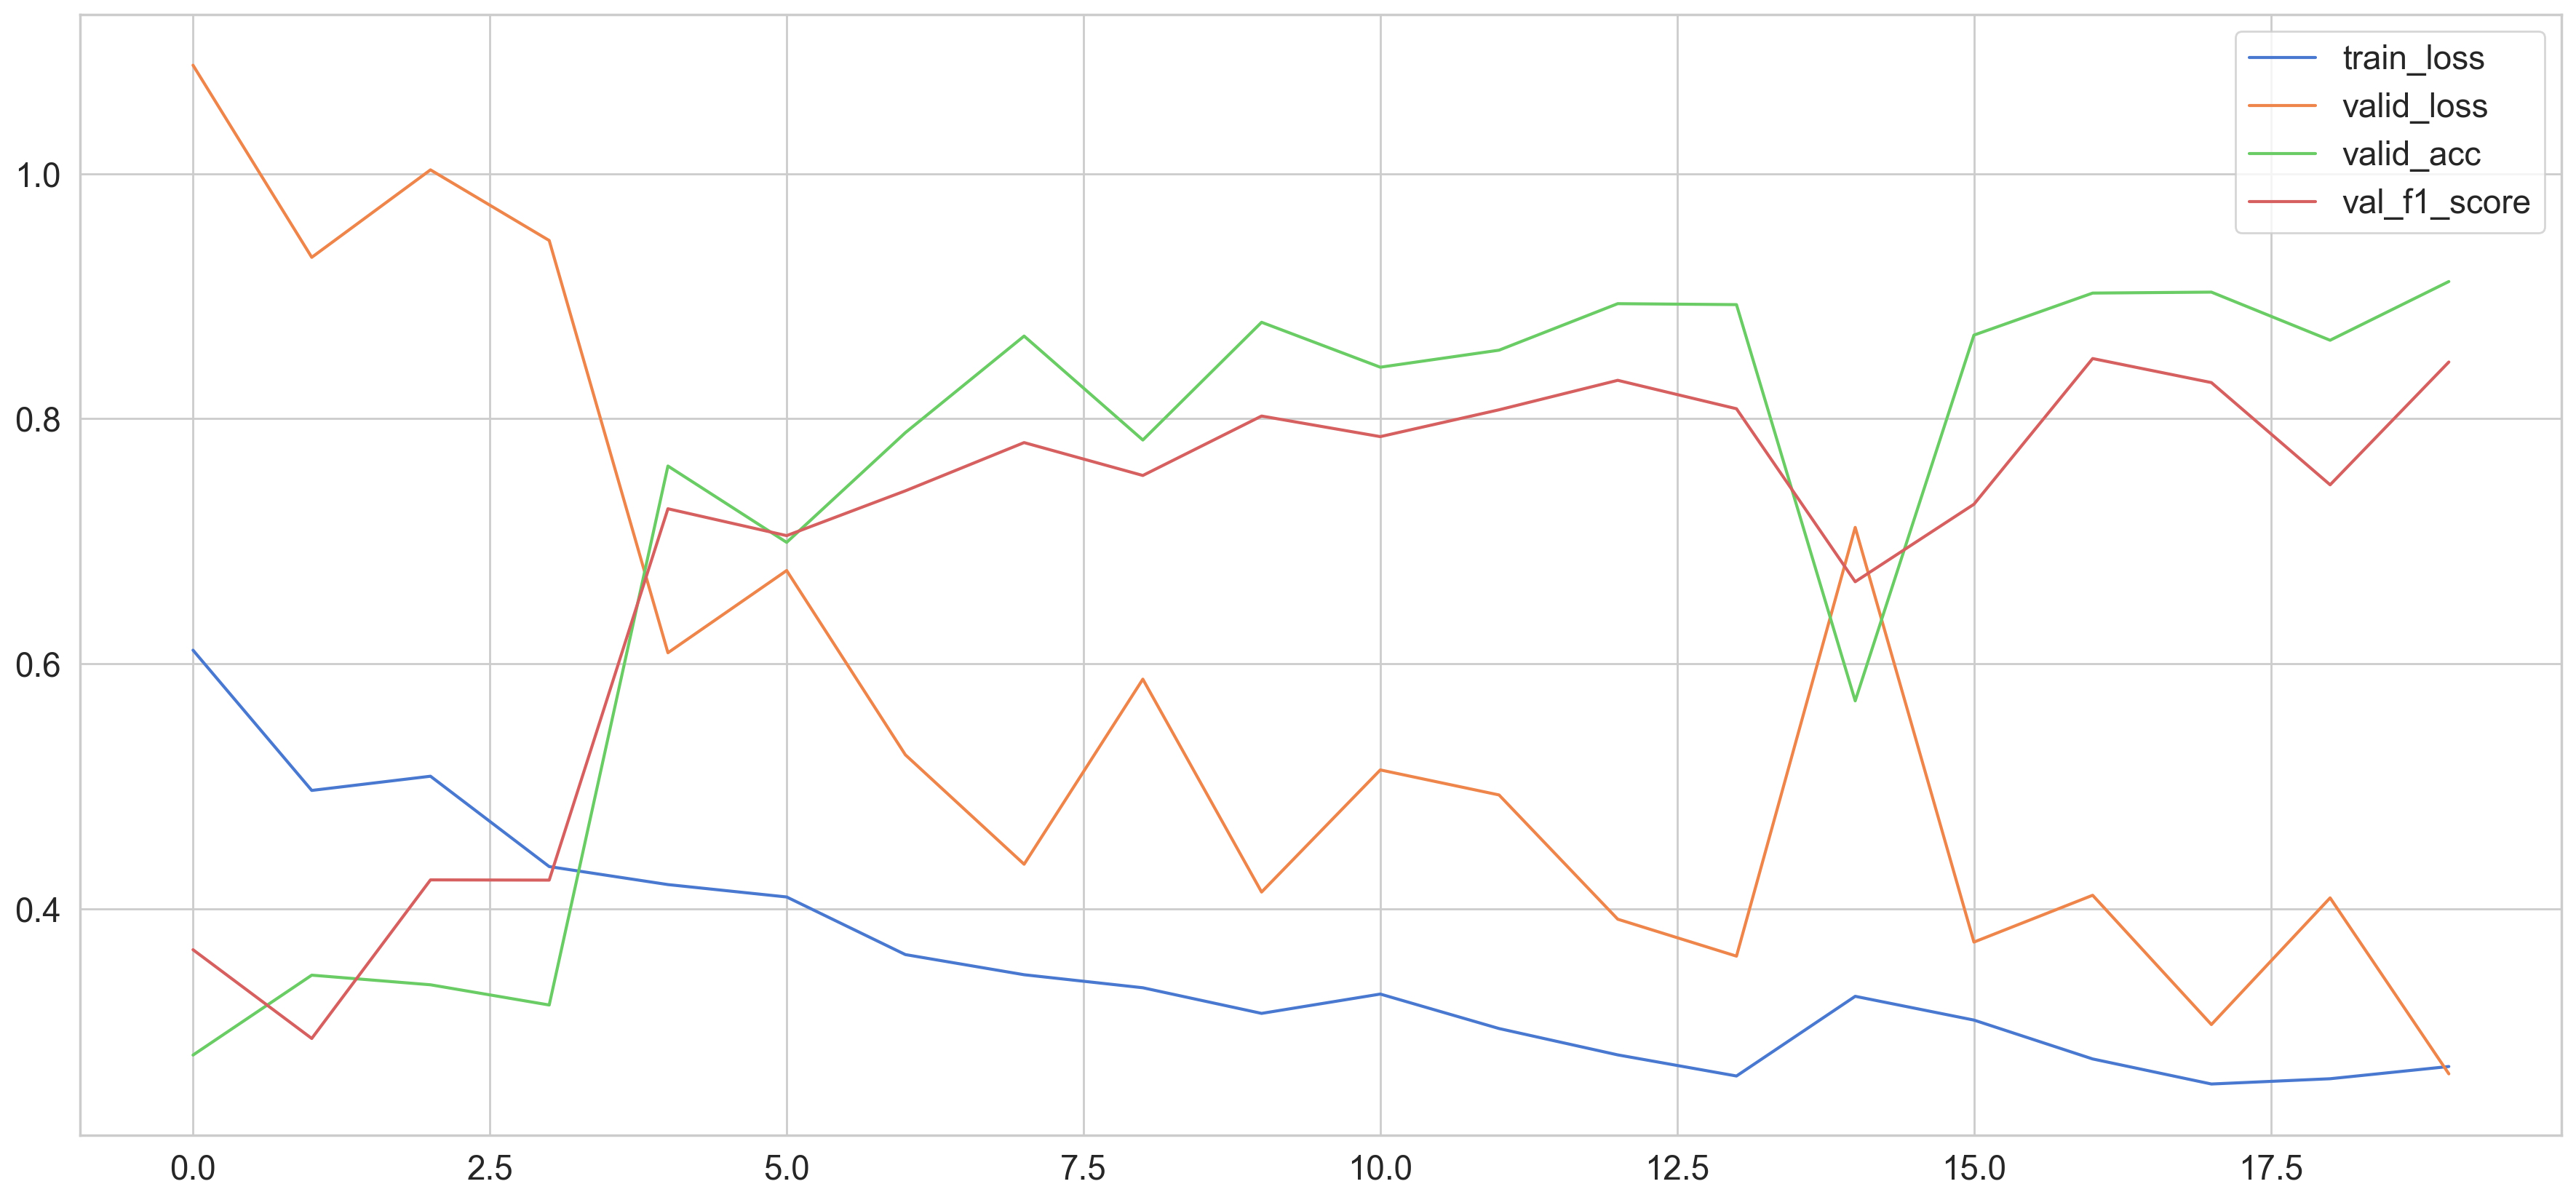

In [218]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='valid_loss')
plt.plot(history.history['val_acc'], label='valid_acc')
plt.plot(history.history['val_f1_score'], label='val_f1_score')

plt.legend();

In [219]:
model.load_weights('training_2/cp-best-f1_score.ckpt')

2023-04-16 17:08:49.678303: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open training_2/cp-best-f1_score.ckpt: FAILED_PRECONDITION: training_2/cp-best-f1_score.ckpt; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [220]:
model.evaluate(X_val, y_val)

120/120 [==============================] - 8s 67ms/step - loss: 0.4111 - acc: 0.9026 - f1_score: 0.8492


[0.41110625863075256, 0.9025923013687134, 0.8491536378860474]

In [221]:
y_pred = model.predict(X_val)

120/120 [==============================] - 9s 70ms/step


In [222]:
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(18, 16)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax
  )

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() # ta-da!

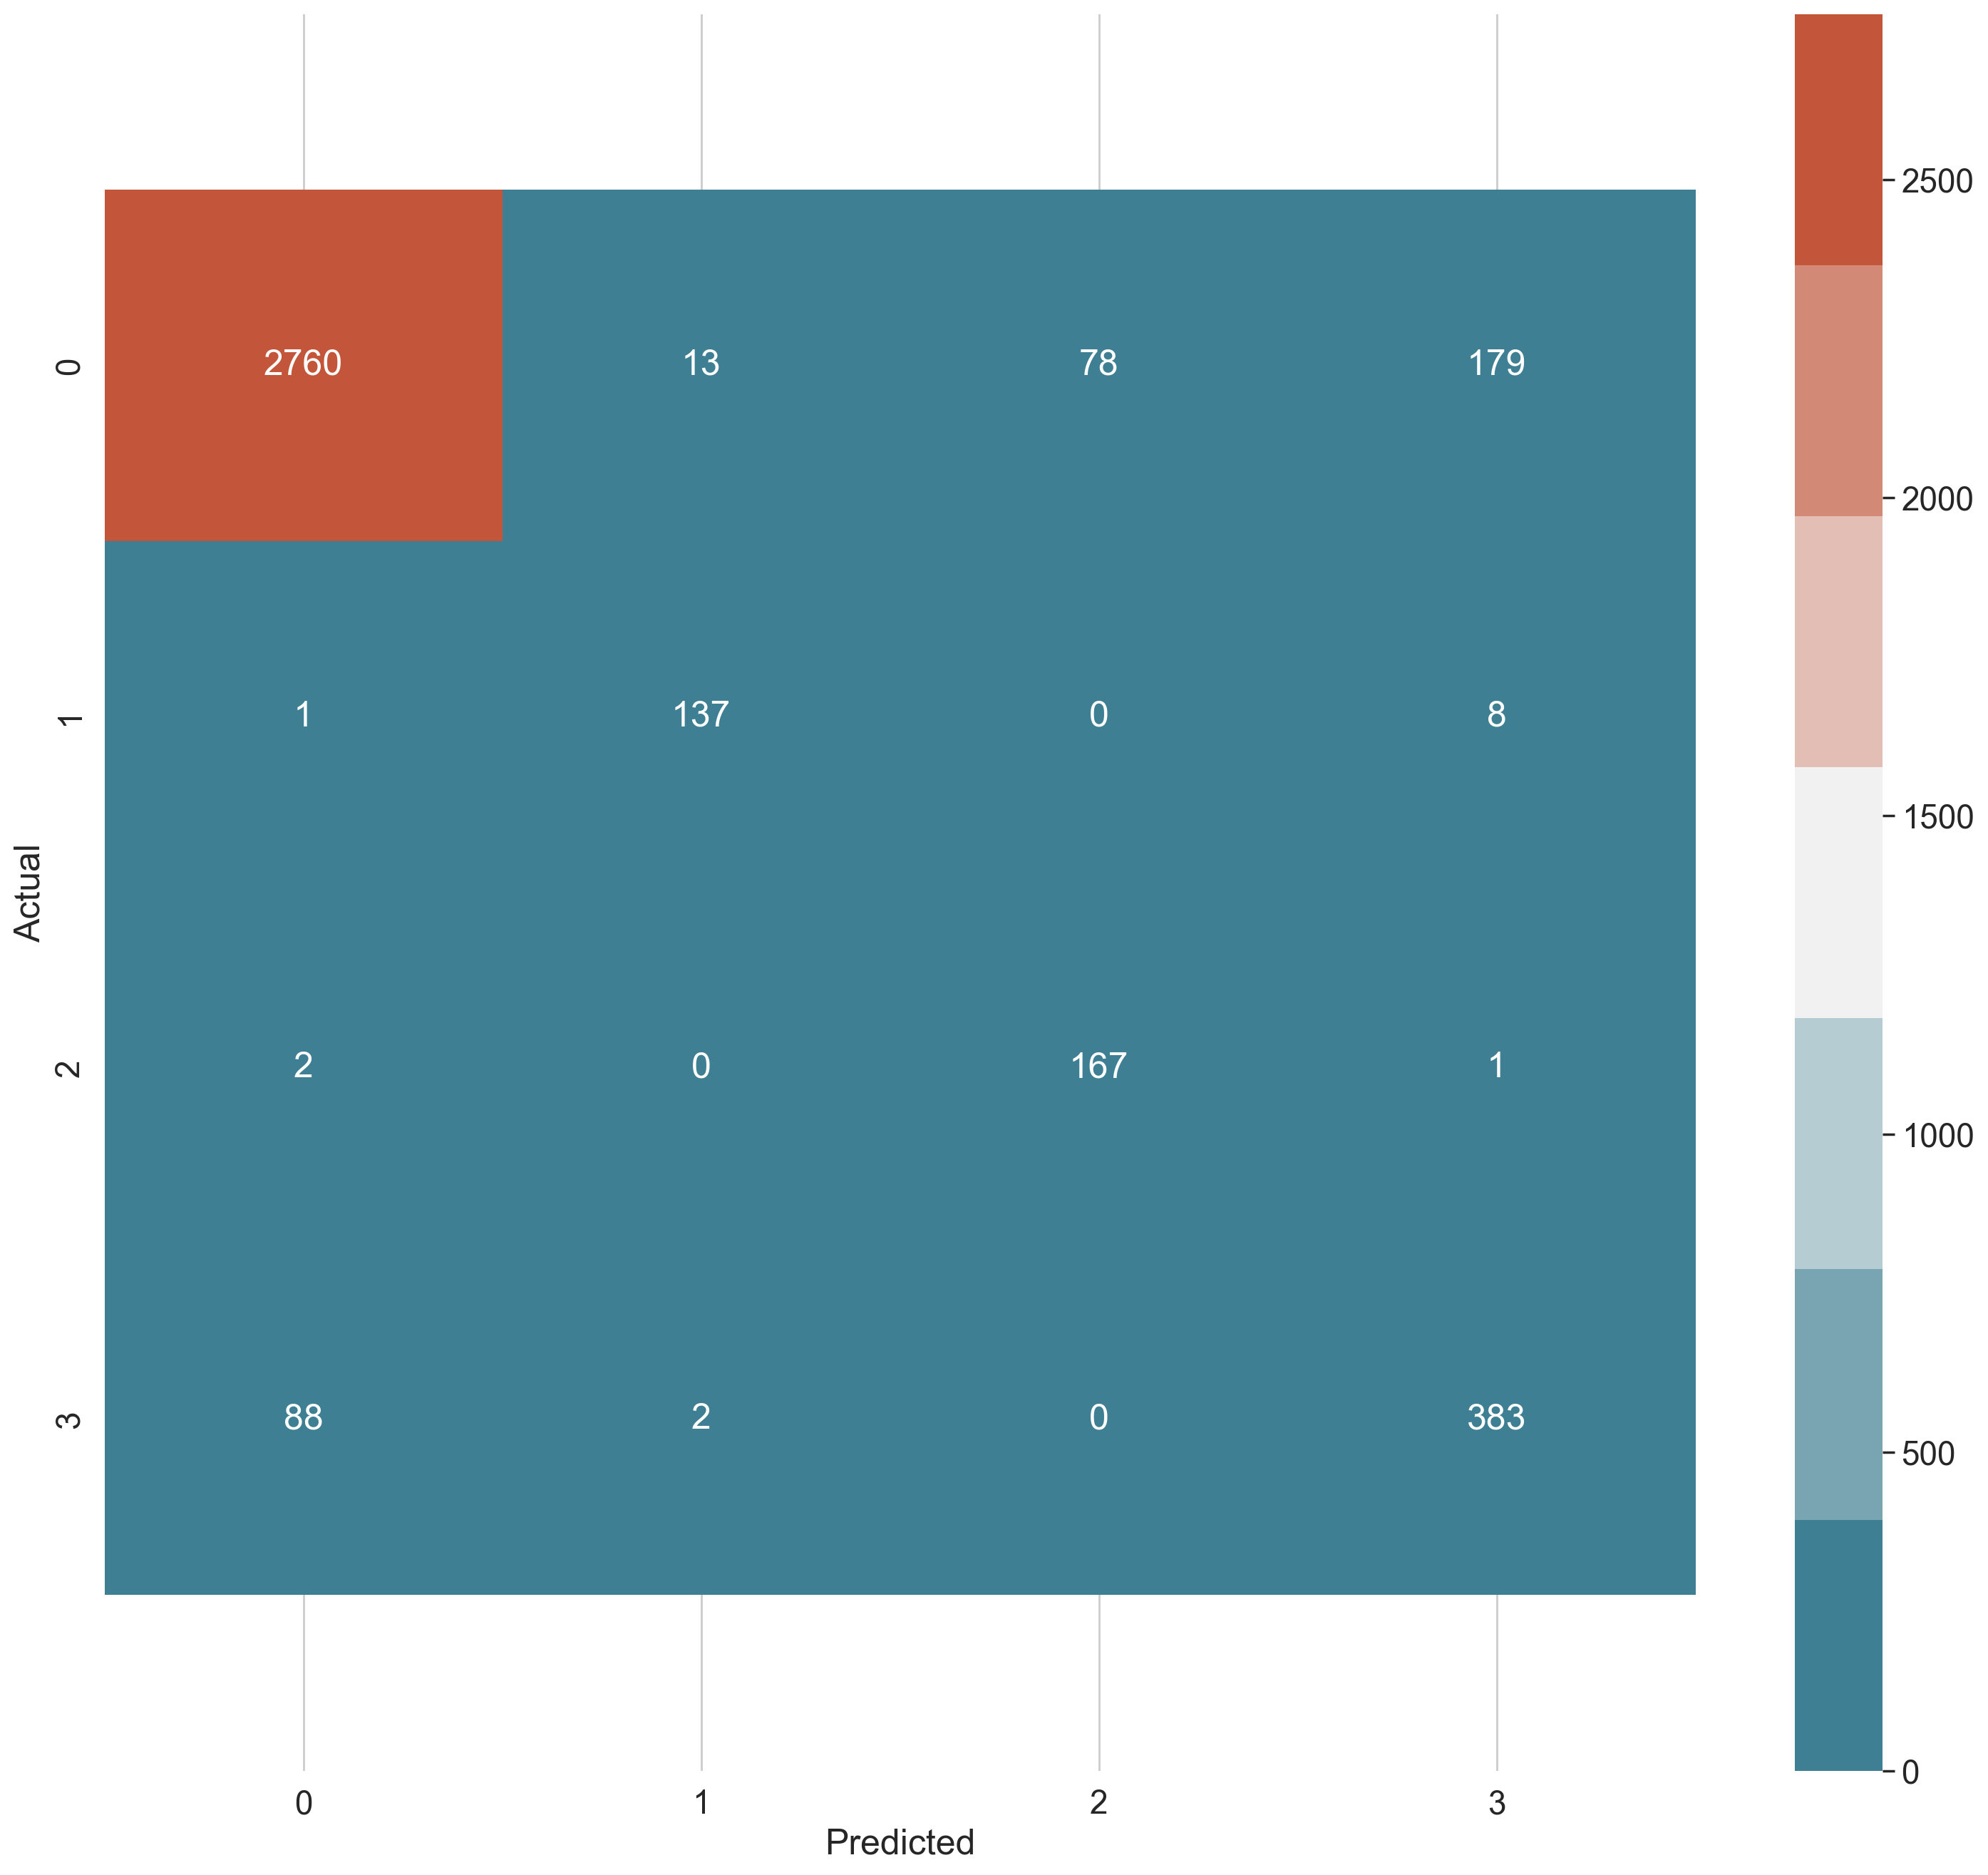

In [223]:
plot_cm(
  enc.inverse_transform(y_val),
  enc.inverse_transform(y_pred),
  enc.categories_[0]
)